# Operational Amplifier Circuit Simulation

## Libraries

In [9]:
from sympy import *
init_printing()
import ipywidgets as wgs

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Unit import *

from ipywidgets import widgets
from IPython.display import display

#https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information sympy, numpy, matplotlib, pandas, PySPice, ipywidgets

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.8 64bit [GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]
IPython 7.5.0
OS Linux 3.10.0 1062.9.1.el7.x86_64 x86_64 with centos 7.7.1908 Core
sympy 1.4
numpy 1.18.5
matplotlib 3.2.2
pandas 1.0.5
PySPice 1.4.3
ipywidgets 7.4.2
Mon Nov 30 08:40:04 2020 EST

In [10]:
%env LD_LIBRARY_PATH=/usr/local/lib
%env

env: LD_LIBRARY_PATH=/usr/local/lib


{'PATH': '/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin',
 'LANG': 'en_US.UTF-8',
 'JUPYTERHUB_API_TOKEN': 'db2ddbe922f9402c97e06cc514f0c996',
 'JPY_API_TOKEN': 'db2ddbe922f9402c97e06cc514f0c996',
 'JUPYTERHUB_CLIENT_ID': 'jupyterhub-user-brash',
 'JUPYTERHUB_HOST': '',
 'JUPYTERHUB_OAUTH_CALLBACK_URL': '/user/brash/oauth_callback',
 'JUPYTERHUB_USER': 'brash',
 'JUPYTERHUB_SERVER_NAME': '',
 'JUPYTERHUB_API_URL': 'http://127.0.0.1:8081/hub/api',
 'JUPYTERHUB_ACTIVITY_URL': 'http://127.0.0.1:8081/hub/api/users/brash/activity',
 'JUPYTERHUB_BASE_URL': '/',
 'JUPYTERHUB_SERVICE_PREFIX': '/user/brash/',
 'USER': 'brash',
 'HOME': '/home/brash',
 'SHELL': '/bin/bash',
 'JPY_PARENT_PID': '17535',
 'TERM': 'xterm-color',
 'CLICOLOR': '1',
 'PAGER': 'cat',
 'GIT_PAGER': 'cat',
 'MPLBACKEND': 'module://ipykernel.pylab.backend_inline',
 'LD_LIBRARY_PATH': '/usr/local/lib'}

# Setup

In [3]:
def lambdify2(expresion, ReVars=False):
    """
    Helper Function to more automate sympy `lambdify` function
    
    Args:
        expresion: sympy expresion !Only Pass LHS of Equations
        ReVars (bool; False): Control to return the Vars in a list if True
    
    Note:
        lambdfy is set with `dummify=False` therefore do not pass
        unsantied variabls to functin else error will be thrown
    """
    #collect vars
    Vars=sorted(list(expresion.free_symbols), key=lambda x: str(x))
    #perform lambdfy with waver
    F=lambdify(Vars, expresion, dummify=False)
    if ReVars:
        return F, Vars
    else:
        return F

# Ideal OpAmp

Using the Semi Ideal OpAmp model devloped by Fabrice Salvaire for the OpAmp Exsample [8.10.3. Operational Amplifier](https://pyspice.fabrice-salvaire.fr/examples/operational-amplifier/operational-amplifier.html)

<img src="SemiIdelOpAmpModel.png">

In [4]:
class BasicOperationalAmplifier(SubCircuitFactory):
    """
    Semi Ideal OpAmp Model SubCir from 
    https://pyspice.fabrice-salvaire.fr/examples/operational-amplifier/operational-amplifier.html
    A0=100e3; pole=100; A=10e6Hz
    Terminals:
        non_inverting_input
        inverting_input
        output
    """

    __name__ = 'BasicOperationalAmplifier'
    __nodes__ = ('non_inverting_input', 'inverting_input', 'output')

    ##############################################

    def __init__(self):

        super().__init__()

        # Input impedance
        self.R('input', 'non_inverting_input', 'inverting_input', 10@u_MΩ)

        # dc gain=100k and pole1=100hz
        # unity gain = dcgain x pole1 = 10MHZ
        self.VCVS('gain', 1, self.gnd, 'non_inverting_input', 'inverting_input', voltage_gain=kilo(100))
        self.R('P1', 1, 2, 1@u_kΩ)
        self.C('P1', 2, self.gnd, 1.5915@u_uF)

        # Output buffer and resistance
        self.VCVS('buffer', 3, self.gnd, 2, self.gnd, 1)
        self.R('out', 3, 'output', 10@u_Ω)

# TestBench

<img src="TestBench1P.png">

In [5]:
class OnePortOpAmpTB(Circuit):
    """
    Class for implimenting Bode plot simulation for One Port 
    (Two Termanal) Opertinal Amplifer topology 
    """
    def __init__(self, DUT, **kwargs):
        """
        Args:
            DUT (class SubCircuitFactory): The One Port OpAmp topology class to be tested
            kwargs (dict): Addital Ciricut Parmters to the topology under test
        """
        #bind the DUT class to TB instance
        self.DUT=DUT
        #self.Theory=self.DUT.Theory()
        #create the ciruit name from DUT name
        super().__init__(title=f'{self.DUT.__name__}_TB', **kwargs)
        
    
    def SetupCir(self, **kwargs):
        """
        Sets up the the DUT and the Testbench for simulation
        see diagrm in source IPYNB for cirucit diagram
        Args:
            kwargs (dict): Addital Ciricut Parmters to the topology under test
        """
        #create instatince of DUT and setuo with parmaters
        self.DUT=self.DUT(**kwargs)
        
        #load the DUT in to the circuit
        self.subcircuit(self.DUT)
        self.X('Amp', self.DUT.__name__, 'Vin', 'Vout')
        
        #set up the TB elements
        self.R('Sload', 'Vin' , '1', 50@u_Ω)
        self.SinusoidalVoltageSource('Source', '1', self.gnd, amplitude=1@u_V)

        self.R('Tload', 'Vout', self.gnd, 50@u_Ω)
        #print out the resulting spice list
        print(self)
    
    def Simulate(self, fMin=1, fMax=20e6):
        """
        Method to perform a Bode plot simulation via NgSpice AC sim @25C
        Args:
            fMin(float; 1 [Hz]): the  starting frequnacy for 
            Bode plot sweep in hertz
            
            fMax(float; 100e3[Hz]): the ending  frequnacy for 
            Bode plot sweep in hertz
        
        Retured Attributes:
            results: the ac simulation raw results from NGSpice
            Data: Pandas Dataframe with ouputs and calcs from results
            
        """
        
        simulator = self.simulator(temperature=25, nominal_temperature=25)
        self.results = simulator.ac(start_frequency=fMin@u_Hz, stop_frequency=fMax@u_Hz, number_of_points=10,  variation='dec')
        
        # returned dataframe
        self.Data=pd.DataFrame()
        self.Data['freq[Hz]']=self.results.frequency
        self.Data['Vin']=self.results.Vin
        self.Data['Vout']=self.results.Vout
        #normlized gain in dB
        self.Data['Gain[dB]']=20*np.log10(np.abs(self.Data['Vout']/self.Data['Vin']))
        # phase in radians unwraped
        self.Data['Phase[rad_UW]']=(np.angle(self.Data['Vout']))
    
    def PlotResults(self):
        """
        Create a Bode plot from the simulation
        """
        self.fig, [self.axMag, self.axPh]=plt.subplots(ncols=1, nrows=2, sharex=True)
        
        A=self.Data['Gain[dB]']; F=self.Data['freq[Hz]']
        L=np.abs(np.abs(A-A.max())-3.0).idxmin()
        self.dB3=F[L]
        
        plt.suptitle("Bode Diagram of an Operational Amplifier")
        bode_diagram(axes=(self.axMag, self.axPh),
                     frequency=self.Data['freq[Hz]'],
                     gain=self.Data['Gain[dB]'],
                     phase=self.Data['Phase[rad_UW]'],
                     marker='.',
                     color='blue',
                     linestyle='-',
                    )
        
        self.axMag.axvline(x=self.dB3, label='3dB[Hz]', 
                      linestyle='-.', alpha=.7, color='g')
        self.axPh.axvline(x=self.dB3, label='3dB[Hz]', 
                      linestyle='-.', alpha=.7, color='g')
        
        
    

\begin{definition}
$A$ Open Loop Gain (no feedback)
$$A=\dfrac{V_o}{V_i}$$
\end{definition}

\begin{definition}
$G$ Closed Loop Gain (with feedback)
$$G=\dfrac{V_o}{V_i}$$
\end{definition}

\begin{definition}
$Z_{\text{i}}$ Open Loop Input Impedance (no feedback)
$$Z_{\text{i}}=\dfrac{V_{\text{diff}}}{I_i}$$
\end{definition}

\begin{definition}
$Z_{\text{o}}$ Open Loop Output Impedance (no feedback)
$$Z_{\text{o}}=\dfrac{V_o}{I_o}$$
\end{definition}

\begin{definition}
$Z_{\text{ifb}}$ Closed Loop Input Impedance (with feedback)
$$Z_{\text{ifb}}=\dfrac{V_i}{I_i}$$
\end{definition}

\begin{definition}
$Z_{\text{ofb}}$ Closed Loop Output Impedance (with feedback)
$$Z_{\text{ofb}}=\dfrac{V_o}{I_o}$$
\end{definition}


\begin{definition}
$V_{\text{diff}}$ the differential input voltage
$$V_{\text{diff}}=V_+-V_-$$
\end{definition}


# Buffer

<img src="Buffer.png">

[Analog Electronics: Circuits, Systems and Signal Processing](https://www.amazon.com/Analog-Electronics-Circuits-Systems-Processing-ebook/dp/B00CXO975A/ref=sr_1_1?ie=UTF8&qid=1524885102&sr=8-1&keywords=Analog+Electronics+Crecraft+Gergely) 3.5, 3.5.1, 3.5.2


$$V_{\text{diff}}=V_i-V_o$$
$$V_o=AV_{\text{diff}}$$
$$V_o=AV_i-AV_o$$
$$G=\dfrac{V_o}{V_i}=\dfrac{A}{1+A}\approx 1$$


$$I_i=\dfrac{V_{\text{diff}}}{Z_i} $$
$$V_{\text{diff}}=\dfrac{1}{1+A}V_i$$
$$I_i=\dfrac{1}{1+A} \dfrac{V_i}{Z_i}$$
$$Z_{\text{ifb}}=(1+A)Z_i$$

$$V_o=AV_{\text{diff}}-I_LZ_o$$
$$(1+A)V_o=AV_i-I_L Z_o$$
$$V_o=\dfrac{A}{1+A}V_i -\dfrac{Z_o}{1+A}I_L$$
$$V_o=GV_i -Z_{\text{ofb}}I_L$$
$$Z_{\text{ifb}}=\dfrac{Z_o}{1+A}$$

In [11]:
class BufferOpAmp(SubCircuitFactory):
    """
    Buffer OpAmp SubCircuit
    Termanals:
        Vin
        Vout
    
    """
    
    __name__='BufferOpAmp'
    __nodes__=('Vin','Vout')
    
    def __init__(self):
        super().__init__()
       
        #'non_inverting_input', 'inverting_input', 'output'
        self.subcircuit(BasicOperationalAmplifier())
        self.X('op', 'BasicOperationalAmplifier', 'Vin', 'Vout', 'Vout')
    
    @staticmethod
    def Theory():
        """Analog Electronics: Circuits, Systems and Signal Processing 
        Crecraft Gergely"""
        A,Zi, Zo, s=symbols('A, Z_i, Z_o s')
        H=Function('H')(s); Zin=Function('Z_ifb')(s); Zout=Function('Z_ofb')(s)
        TF=Eq(H, A/(1+A)); Zin=Eq(Zin, (1+A)*Zi); Zout=Eq(Zout, Zo/(1+A))
        return TF, Zin, Zout
    

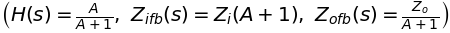

In [12]:
#Print out the Buffer Op Amp Theory
BufferOpAmp.Theory()

.title BufferOpAmp_TB
.subckt BufferOpAmp Vin Vout
.subckt BasicOperationalAmplifier non_inverting_input inverting_input output
Rinput non_inverting_input inverting_input 10MegOhm
Egain 1 0 non_inverting_input inverting_input 100k
RP1 1 2 1kOhm
CP1 2 0 1.5915uF
Ebuffer 3 0 2 0 1
Rout 3 output 10Ohm
.ends BasicOperationalAmplifier
Xop Vin Vout Vout BasicOperationalAmplifier
.ends BufferOpAmp
XAmp Vin Vout BufferOpAmp
RSload Vin 1 50Ohm
VSource 1 0 DC 0V AC 1V SIN(0V 1V 50Hz 0s 0Hz)
RTload Vout 0 50Ohm



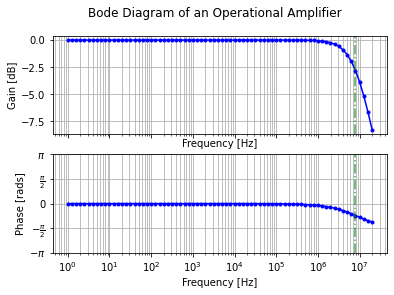

In [13]:
#create the Test Bench and Bind to this instance the BufferOpAmp Topo
TB=OnePortOpAmpTB(BufferOpAmp)
#Setup the Testbench and print the TB
TB.SetupCir()
#Run the AC Bode Simulation
TB.Simulate()
#View Bode Simulation
TB.PlotResults()

# Inverting

<img src="InvertingOpAmp.png">

In [ ]:
class InvertingOpAmp(SubCircuitFactory):
    """
    Inverting OpAmp SubCir
    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        R2[Ohms]
    """
    
    __name__='InvertingOpAmp'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, R2=1):
        super().__init__()
        self.R1=R1; self.R2=R2
        
        self.R('1', 'Vin', '2', R1@u_Ω)
        self.R('2', '2', 'Vout', R2@u_Ω)
        
        self.subcircuit(BasicOperationalAmplifier())
        self.X('op', 'BasicOperationalAmplifier', self.gnd, '2', 'Vout')
        self.Theory()
    
    @staticmethod
    def Theory():
        """Analog Electronics: Circuits, Systems and Signal Processing 
        Crecraft Gergely"""        
        R1, R2=symbols('R_1, R_2', real=True, postive=True)
        A,Zi, Zo, s=symbols('A, Z_i, Z_o s')
        H=Function('H')(s); Zin=Function('Z_in')(s); Zout=Function('Z_out')(s)
        TF=Eq(H, -R2/R1)
        Zin=Eq(Zin, R1)
        Zout=Eq(Zout, Zo*(R1+R2)/(A*R1))
        return TF, Zin, Zout
        
    

In [ ]:
#Print out the Inverting Op Amp Theory
InvertingOpAmp.Theory()

In [ ]:
class InvertingExp():
    """
    Class to provide GUI for Inverting Amplifer
    """
    def __init__(self):
        """
        Front end and binding to backend
        """
        #create the GUI elments
        self.R1Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R1 kOhm',
                                         )
        self.R2Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R2 kOhm',
                                         )
        #layout
        self.RSVBox=widgets.VBox([self.R1Slider, self.R2Slider])
        
        #bind to the backend
        I=widgets.interact_manual(self.BackEnd, R1=self.R1Slider, 
                              R2=self.R2Slider)
        display(I)
    
    def BackEnd(self, R1, R2):
        """
        The backend wrapper to the TB and simulation
        """
        
        #create the Test Bench and Bind to this instance the InvertingOpAmp Topo
        TB=OnePortOpAmpTB(InvertingOpAmp)
        #Setup the Testbench; use a R1=20 Ohm,R2=5 Ohm and print the TB
        TB.SetupCir(**{'R1':R1*1e3, 'R2':R2*1e3})
        #Run the AC Bode Simulation
        TB.Simulate()
        #View Bode Simulation
        TB.PlotResults()


In [ ]:
InvertingExp();

# Noninverting

<img src="NonInveringOpAmp.png">

In [ ]:
class NonInvertingOpAmp(SubCircuitFactory):
    """
    Non-Inverting OpAmp SubCir
    Termanals:
        Vin
        Vout
    Parms:
        R1
        R2
    """
    
    __name__='NonInvertingOpAmp'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1, R2):
        super().__init__()
        self.R1=R1; self.R2=R2
        
        self.R('1', '2', self.gnd, R1@u_Ω)
        self.R('2', '2', 'Vout', R2@u_Ω)
        
        self.subcircuit(BasicOperationalAmplifier())
        self.X('op', 'BasicOperationalAmplifier', 'Vin', '2', 'Vout')
    
    @staticmethod
    def Theory():
        """Analog Electronics: Circuits, Systems and Signal Processing 
        Crecraft Gergely"""        
        R1, R2=symbols('R_1, R_2', real=True, postive=True)
        A,Zi, Zo, s=symbols('A, Z_i, Z_o s')
        H=Function('H')(s); Zin=Function('Z_in')(s); Zout=Function('Z_out')(s)
        TF=Eq(H, (A(R1+R2))/(R2(1+A)+R1))
        Zin=Eq(Zin, Zi*((1+A)*R2+R1)/(R2+(1-A)*R1))
        Zout=Eq(Zout, Zo*(R1+R2)/(R1+(1+A)*R2))
        return TF, Zin, Zout
        


In [ ]:
#Print out the NonInverting Op Amp Theory
NonInvertingOpAmp.Theory()

In [ ]:
class NonInvertingExp():
    """
    Class to provide GUI for Inverting Amplifer
    """
    def __init__(self):
        """
        Front end and binding to backend
        """
        #create the GUI elments
        self.R1Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R1 kOhm'
                                         )
        self.R2Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R2 kOhm'
                                         )
        #layout
        self.RSVBox=widgets.VBox([self.R1Slider, self.R2Slider])
        
        #bind to the backend
        I=widgets.interact_manual(self.BackEnd, R1=self.R1Slider, 
                              R2=self.R2Slider)
        display(I)
    
    def BackEnd(self, R1, R2):
        """
        The backend wrapper to the TB and simulation
        """
        
        #create the Test Bench and Bind to this instance the NonInverting Topo
        TB=OnePortOpAmpTB(NonInvertingOpAmp)
        #Setup the Testbench; use a R1=20 Ohm,R2=5 Ohm and print the TB
        TB.SetupCir(**{'R1':R1*1e3, 'R2':R2*1e3})
        #Run the AC Bode Simulation
        TB.Simulate()
        #View Bode Simulation
        TB.PlotResults()


In [ ]:
NonInvertingExp();

# Miller Capactive Integrator 

<img src="MillerCapInt.png">

In [ ]:
class MillerCapIntOpAmp(SubCircuitFactory):
    """
    Inverting OpAmp SubCir
    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        C1[Fards]
    """
    
    __name__='MillerCapIntOpAmp'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, C1=1):
        super().__init__()
        self.R1=R1; self.C1=C1
        
        self.R('1', 'Vin', '2', R1@u_Ω)
        self.C('1', '2', 'Vout', C1@u_F)
        
        self.subcircuit(BasicOperationalAmplifier())
        self.X('op', 'BasicOperationalAmplifier', self.gnd, '2', 'Vout')
        self.Theory()
    
    @staticmethod
    def Theory():
        """Analog Electronics: Circuits, Systems and Signal Processing 
        Crecraft Gergely"""        
        R1, C1=symbols('R_1, C_1', real=True, postive=True)
        A,Zi, Zo, s=symbols('A, Z_i, Z_o s')
        H=Function('H')(s); Zin=Function('Z_in')(s); Zout=Function('Z_out')(s)
        TF=Eq(H, -(1/(s*C1))/R1)
        Zin=simplify(Eq(Zin, R1))
        Zout=Eq(Zout, Zo/(A(1+s*C1*R1)))
        return TF, Zin, Zout
        
    

In [ ]:
#Print out the MillerCapInt Op Amp Theory
MillerCapIntOpAmp.Theory()

In [ ]:
class MillerCapIntExp():
    """
    Class to provide GUI for  MillerCapInt
    """
    def __init__(self):
        """
        Front end and binding to backend
        """
        #create the GUI elments
        self.R1Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R1 kOhm',
                                         readout_format='.1e')
        self.C1Slider=widgets.FloatSlider(value=50,
                                         min=1, max=500, step=25,
                                         description='C1 pF')
        #layout
        self.RSVBox=widgets.VBox([self.R1Slider, self.C1Slider])
        
        #bind to the backend
        I=widgets.interact_manual(self.BackEnd, R1=self.R1Slider, 
                              C1=self.C1Slider)
        display(I)
    
    def BackEnd(self, R1, C1):
        """
        The backend wrapper to the TB and simulation
        """
        
        #create the Test Bench and Bind to this instance the MillerCapInt Topo
        TB=OnePortOpAmpTB(MillerCapIntOpAmp)
        #Setup the Testbench; use a R1=20 Ohm,C1=10 muF and print the TB
        TB.SetupCir(**{'R1':R1*1e3, 'C1':C1*1e-12})
        #Run the AC Bode Simulation
        TB.Simulate()
        #View Bode Simulation
        TB.PlotResults()

In [ ]:
MillerCapIntExp()


# Miller Inductive Integrator 

<img src="MillerIndInt.png">

In [ ]:
class MillerIndIntOpAmp(SubCircuitFactory):
    """
    Inverting OpAmp SubCir
    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        L1[Henrys]
    """
    
    __name__='MillerIndIntOpAmp'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, L1=1):
        super().__init__()
        self.R1=R1; self.L1=L1
        
        self.L('1', 'Vin', '2', L1@u_H)
        self.R('1', '2', 'Vout', R1@u_Ω)
        
        self.subcircuit(BasicOperationalAmplifier())
        self.X('op', 'BasicOperationalAmplifier', self.gnd, '2', 'Vout')
        self.Theory()
    
    @staticmethod
    def Theory():
        """Analog Electronics: Circuits, Systems and Signal Processing 
        Crecraft Gergely"""        
        R1, L1=symbols('R_1, L_1', real=True, postive=True)
        A,Zi, Zo, s=symbols('A, Z_i, Z_o s')
        H=Function('H')(s); Zin=Function('Z_in')(s); Zout=Function('Z_out')(s)
        TF=Eq(H, -R1/(s*L1))
        Zin=Eq(Zin, s*L1)
        Zout=simplify(Eq(Zout, Zo*(s*L1+R1)/(A*s*L1)))
        return TF, Zin, Zout
        

In [ ]:
#Print out the MillerIndInt Op Amp Theory
MillerIndIntOpAmp.Theory()

In [ ]:
class MillerIndIntExp():
    """
    Class to provide GUI for  MillerIndInt
    """
    def __init__(self):
        """
        Front end and binding to backend
        """
        #create the GUI elments
        self.R1Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R1 kOhm',
                                         readout_format='.1e')
        self.L1Slider=widgets.FloatSlider(value=50,
                                         min=1, max=500, step=25,
                                         description='L1 uH')
        #layout
        self.RSVBox=widgets.VBox([self.R1Slider, self.L1Slider])
        
        #bind to the backend
        I=widgets.interact_manual(self.BackEnd, R1=self.R1Slider, 
                              L1=self.L1Slider)
        display(I)
    
    def BackEnd(self, R1, L1):
        """
        The backend wrapper to the TB and simulation
        """
        
        #create the Test Bench and Bind to this instance the MillerCapInt Topo
        TB=OnePortOpAmpTB(MillerIndIntOpAmp)
        #Setup the Testbench; use a R1=20 Ohm,L1=10 muH and print the TB
        TB.SetupCir(**{'R1':R1*1e3, 'L1':L1*1e-6})
        #Run the AC Bode Simulation
        TB.Simulate()
        #View Bode Simulation
        TB.PlotResults()

In [ ]:
MillerIndIntExp();

#  Low Pass 1Pole

<img src="LowPass1P.png">

In [ ]:
class LowPass1POpAmp(SubCircuitFactory):
    """
    Single Pole Low Pass OpAmp SubCir

    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        R2[Ohms]
        C1[Farads]
    """
    
    __name__='LowPass1POpAmp'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, R2=1, C1=1):
        super().__init__()
        self.R1=R1; self.R2=R2; self.C1=C1
        
        self.R('1', 'Vin', '2', R1@u_Ω)
        self.R('2', '2', 'Vout', R2@u_Ω)
        self.C('1', '2', 'Vout', C1@u_F)
        
        self.subcircuit(BasicOperationalAmplifier())
        #non, inv, out
        self.X('op', 'BasicOperationalAmplifier', 'Vin', '2', 'Vout')
        
    @staticmethod
    def Theory():
        """Analog Electronics: Circuits, Systems and Signal Processing 
        Crecraft Gergely"""        
        R1, R2, C1=symbols('R_1, R_2, C_1', real=True, postive=True)
        A,Zi, Zo, s=symbols('A, Z_i, Z_o s')
        H=Function('H')(s); Zin=Function('Z_in')(s); Zout=Function('Z_out')(s)
        TF=simplify(Eq(H, -(R2/(R2*s*C1+1))/R1))
        Zin=Eq(Zin, R1)
        Zout=simplify(Eq(Zout, Zo*(R1+(R2/(R2*s*C1+1)))/(A*R1)))
        return TF, Zin, Zout
        


In [ ]:
LowPass1POpAmp.Theory()

In [ ]:
class LowPass1POpAmpExp():
    """
    Class to provide GUI for  LowPass1POpAmp
    """
    def __init__(self):
        """
        Front end and binding to backend
        """
        #create the GUI elments
        self.R1Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R1 kOhm',
                                         readout_format='.1e')
        
        self.R2Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R2 kOhm',
                                         readout_format='.1e')
        
        self.C1Slider=widgets.FloatSlider(value=50,
                                         min=1, max=500, step=25,
                                         description='C1 pF')
        #layout
        self.RSVBox=widgets.VBox([self.R1Slider, self.R2Slider, self.C1Slider])
        
        #bind to the backend
        I=widgets.interact_manual(self.BackEnd, R1=self.R1Slider,
                                  R2=self.R2Slider,
                              C1=self.C1Slider)
        display(I)
    
    def BackEnd(self, R1, R2, C1):
        """
        The backend wrapper to the TB and simulation
        """
        
        #create the Test Bench and Bind to this instance the LowPass1POpAmp Topo
        TB=OnePortOpAmpTB(LowPass1POpAmp)
        #Setup the Testbench; use a R1=20 Ohm, R2=5 Ohm,C1=10 muH and print the TB
        TB.SetupCir(**{'R1':R1*1e3, 'R2':R2*1e3, 'C1':C1*1e-12})
        #Run the AC Bode Simulation
        TB.Simulate()
        #View Bode Simulation
        TB.PlotResults()



In [ ]:
LowPass1POpAmpExp();

# Miller Capacitive Differentiator 

<img src="MillerCapDiff.png">

In [ ]:
class MillerCapDiff(SubCircuitFactory):
    """
    Miller Capacitive Differentiator  OpAmp SubCir
    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        C1[Farads]
    """
    
    __name__='MillerCapDiff'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, C1=1):
        super().__init__()
        self.R1=R1; self.C1=C1
        
        self.C('1', 'Vin', '2', C1@u_F)
        self.R('1', '2', 'Vout', R1@u_Ω)
        
        self.subcircuit(BasicOperationalAmplifier())
        self.X('op', 'BasicOperationalAmplifier', self.gnd, '2', 'Vout')
        self.Theory()
    
    @staticmethod
    def Theory():
        """Analog Electronics: Circuits, Systems and Signal Processing 
        Crecraft Gergely"""        
        R1, R2, C1=symbols('R_1, R_2, C_1', real=True, postive=True)
        A,Zi, Zo, s=symbols('A, Z_i, Z_o s')
        H=Function('H')(s); Zin=Function('Z_in')(s); Zout=Function('Z_out')(s)
        TF=Eq(H, -R1/(1/(s*C1)))
        Zin=Eq(Zin, (1/(s*C1)))
        Zout=simplify(Eq(Zout, Zo*((1/(s*C1))+R1)/(A*(1/(s*C1)))))
        return TF, Zin, Zout
    

In [ ]:
MillerCapDiff.Theory()

In [ ]:
class MillerCapDiffExp():
    """
    Class to provide GUI for  MillerCapDiff
    """
    def __init__(self):
        """
        Front end and binding to backend
        """
        #create the GUI elments
        self.R1Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R1 kOhm',
                                         readout_format='.1e')
        self.C1Slider=widgets.FloatSlider(value=50,
                                         min=1, max=500, step=25,
                                         description='C1 pF')
        #layout
        self.RSVBox=widgets.VBox([self.R1Slider, self.C1Slider])
        
        #bind to the backend
        I=widgets.interact_manual(self.BackEnd, R1=self.R1Slider, 
                              C1=self.C1Slider)
        display(I)
    
    def BackEnd(self, R1, C1):
        """
        The backend wrapper to the TB and simulation
        """
        
        #create the Test Bench and Bind to this instance the MillerCapDiff Topo
        TB=OnePortOpAmpTB(MillerCapDiff)
        #Setup the Testbench; use a R1=20 Ohm,C1=10 muF and print the TB
        TB.SetupCir(**{'R1':R1*1e3, 'C1':C1*1e-12})
        #Run the AC Bode Simulation
        TB.Simulate()
        #View Bode Simulation
        TB.PlotResults()

In [ ]:
MillerCapDiffExp();

# Miller Inductive Differentiator 

<img src="MillerIndDiff.png">

In [ ]:
class MillerIndDiff(SubCircuitFactory):
    """
    Miller Inductive Differentiator  OpAmp SubCir
    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        L1[Henerys]
    """
    
    __name__='MillerIndDiff'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, L1=1):
        super().__init__()
        self.R1=R1; self.L1=L1
        
        self.R('1', 'Vin', '2', R1@u_Ω)
        self.L('1', '2', 'Vout', L1@u_H)
        
        self.subcircuit(BasicOperationalAmplifier())
        self.X('op', 'BasicOperationalAmplifier', self.gnd, '2', 'Vout')
        self.Theory()
    
    @staticmethod
    def Theory():
        """Analog Electronics: Circuits, Systems and Signal Processing 
        Crecraft Gergely"""        
        R1, R2, L1=symbols('R_1, R_2, L_1', real=True, postive=True)
        A,Zi, Zo, s=symbols('A, Z_i, Z_o s')
        H=Function('H')(s); Zin=Function('Z_in')(s); Zout=Function('Z_out')(s)
        TF=Eq(H, -(s*L1)/R1)
        Zin=Eq(Zin, R1)
        Zout=Eq(Zout, Zo*(R1+(s*L1))/(A*R1))
        return TF, Zin, Zout
        

In [ ]:
MillerIndDiff.Theory()

In [ ]:
class MillerIndDiffExp():
    """
    Class to provide GUI for  MillerIndDiff
    """
    def __init__(self):
        """
        Front end and binding to backend
        """
        #create the GUI elments
        self.R1Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R1 kOhm',
                                         readout_format='.1e')
        self.L1Slider=widgets.FloatSlider(value=50,
                                         min=1, max=500, step=25,
                                         description='L1 uH')
        #layout
        self.RSVBox=widgets.VBox([self.R1Slider, self.L1Slider])
        
        #bind to the backend
        I=widgets.interact_manual(self.BackEnd, R1=self.R1Slider, 
                              L1=self.L1Slider)
        display(I)
    
    def BackEnd(self, R1, L1):
        """
        The backend wrapper to the TB and simulation
        """
        
        #create the Test Bench and Bind to this instance the MillerCapInt Topo
        TB=OnePortOpAmpTB(MillerIndDiff)
        #Setup the Testbench; use a R1=20 Ohm,L1=10 muH and print the TB
        TB.SetupCir(**{'R1':R1*1e3, 'L1':L1*1e-12})
        #Run the AC Bode Simulation
        TB.Simulate()
        #View Bode Simulation
        TB.PlotResults()

In [ ]:
MillerIndDiffExp();

# High Pass 1Zero

<img src="HighPass1Z.png">

In [ ]:
class HighPass1ZOpAmp(SubCircuitFactory):
    """
    Single Pole Low Pass OpAmp SubCir

    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        R2[Ohms]
        L1[Henerys]
    """
    
    __name__='HighPass1ZOpAmp'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, R2=1, L1=1):
        super().__init__()
        self.R1=R1; self.R2=R2; self.L1=L1
        
        self.R('1', 'Vin', '2', R1@u_Ω)
        self.R('2', '2', 'Vout', R2@u_Ω)
        self.L('1', '2', 'Vout', L1@u_H)
        
        self.subcircuit(BasicOperationalAmplifier())
        #non, inv, out
        self.X('op', 'BasicOperationalAmplifier', 'Vin', '2', 'Vout')
        
    @staticmethod
    def Theory():
        """Analog Electronics: Circuits, Systems and Signal Processing 
        Crecraft Gergely"""        
        R1, R2, L1=symbols('R_1, R_2, L_1', real=True, postive=True)
        A,Zi, Zo, s=symbols('A, Z_i, Z_o s')
        H=Function('H')(s); Zin=Function('Z_in')(s); Zout=Function('Z_out')(s)
        TF=simplify(Eq(H, -((R2*s*L1)/(s*L1+R2))/R1))
        Zin=Eq(Zin, R1)
        Zout=simplify(Eq(Zout, Zo*(R1+((R2*s*L1)/(s*L1+R2)))/(A*R1)))
        return TF, Zin, Zout
        


In [ ]:
HighPass1ZOpAmp.Theory()

In [ ]:
class HighPass1ZExp():
    """
    Class to provide GUI for  HighPass1ZOpAmp
    """
    def __init__(self):
        """
        Front end and binding to backend
        """
        #create the GUI elments
        self.R1Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R1 kOhm',
                                         readout_format='.1e')
        
        self.R2Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R2 kOhm',
                                         readout_format='.1e')
        
        self.L1Slider=widgets.FloatSlider(value=50,
                                         min=1, max=500, step=25,
                                         description='L1 uH')
        #layout
        self.RSVBox=widgets.VBox([self.R1Slider, self.R2Slider, self.L1Slider])
        
        #bind to the backend
        I=widgets.interact_manual(self.BackEnd, R1=self.R1Slider,
                                  R2=self.R2Slider,
                              L1=self.L1Slider)
        display(I)
    
    def BackEnd(self, R1, R2, L1):
        """
        The backend wrapper to the TB and simulation
        """
        
        #create the Test Bench and Bind to this instance the HighPass1ZOpAmp Topo
        TB=OnePortOpAmpTB(HighPass1ZOpAmp)
        #Setup the Testbench; use a R1=20 Ohm,R2=5 Ohm, L1=10 muH and print the TB
        TB.SetupCir(**{'R1':R1*1e3, 'R2':R2*1e3, 'L1':L1*1e-6})
        #Run the AC Bode Simulation
        TB.Simulate()
        #View Bode Simulation
        TB.PlotResults()



In [ ]:
HighPass1ZExp();

# AllPass (Phase) Filter
http://www.analog.com/media/en/training-seminars/tutorials/MT-202.pdf

## First Order Cap First 
<img src="AllPase1stCap1st.png">

In [ ]:
class AllPass1CapFOpAmp(SubCircuitFactory):
    """
    AllPass 1st Order Cap First
    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        R2[Ohms]
        R3[Ohms]
        C1[Farads]
        
    """
    
    __name__='AllPass1CapFOpAmp'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, R2=1, R3=1, C1=1):
        super().__init__()
        self.R1=R1; self.R2=R2; self.R3=R3
        self.C1=C1
        
        #inverting feedback stucter
        self.R('1', 'Vin', '2', R1@u_Ω)
        self.R('2', '2', 'Vout', R2@u_Ω)
        
        #Voltage Divider
        self.C('1', 'Vin', '3', C1@u_F)
        self.R('3', '3', self.gnd, R3@u_Ω)
        
        self.subcircuit(BasicOperationalAmplifier())
        self.X('op', 'BasicOperationalAmplifier', '3', '2', 'Vout')
        self.Theory()
    
    @staticmethod
    def Theory():
        A, R1, R2, R3, C1=symbols('A, R_1, R_2, R_3, C_1', real=True, postive=True)
        Vn, Vp, Vo, Vi=symbols('V_n, V_p, V_o, V_i')
        s=symbols('s')
        VpEq=Eq(Vp, (s*C1*R3)/(1+s*C1*R3)* Vi); VpEq
        VnEq=Eq(Vn, (R1/(R1+R2))*Vo+(R2/(R1+R2))*Vi); VnEq
        VoEq=Eq(Vo, A*(Vp-Vn)); VoEq
        VoEq=VoEq.subs({VpEq.lhs: VpEq.rhs, VnEq.lhs:VnEq.rhs})
        H=Function('H')(s)
        TF=Eq(H, (solve(VoEq, Vo)[0]/Vi)); TF
        return TF


In [ ]:
class AllPass1CapFExp():
    """
    Class to provide GUI for Inverting AllPass1CapF
    """
    def __init__(self):
        """
        Front end and binding to backend
        """
        #create the GUI elments
        self.R1Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R1 kOhm',
                                         )
        self.R2Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R2 kOhm',
                                         )
        
        self.R3Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R2 kOhm',
                                         )
        
        
        self.C1Slider=widgets.FloatSlider(value=50,
                                         min=1, max=500, step=25,
                                         description='C1 pF')
        #layout
        self.RSVBox=widgets.VBox([self.R1Slider, self.R2Slider])
        
        #bind to the backend
        I=widgets.interact_manual(self.BackEnd, R1=self.R1Slider, 
                              R2=self.R2Slider, R3=self.R3Slider, C1=self.C1Slider)
        display(I)
    
    def BackEnd(self, R1, R2, R3, C1):
        """
        The backend wrapper to the TB and simulation
        """
        
        #create the Test Bench and Bind to this instance the HighPass1ZOpAmp Topo
        TB=OnePortOpAmpTB(AllPass1CapFOpAmp)
        #Setup the Testbench; use a R1=20 Ohm,R2=5 Ohm, L1=10 muH and print the TB
        TB.SetupCir(**{'R1':R1*1e3, 'R2':R2*1e3, 'R3':R3*1e3, 'C1':C1*1e-9})
        #Run the AC Bode Simulation
        TB.Simulate()
        #View Bode Simulation
        TB.PlotResults()


In [ ]:
AllPass1CapFExp()

## First Order Cap Second 
<img src="AllPase1stCap2nd.png">

In [ ]:
class AllPass1CapSOpAmp(SubCircuitFactory):
    """
    AllPass 1st Order Cap Second
    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        R2[Ohms]
        R3[Ohms]
        C1[Farads]
        
    """
    
    __name__='AllPass1CapSOpAmp'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, R2=1, R3=1, C1=1):
        super().__init__()
        self.R1=R1; self.R2=R2; self.R3=R3
        self.C1=C1
        
        #inverting feedback stucter
        self.R('1', 'Vin', '2', R1@u_Ω)
        self.R('2', '2', 'Vout', R2@u_Ω)
        
        #Voltage Divider
        self.R('3', 'Vin', '3', R3@u_Ω)
        self.C('1', '3', self.gnd, C1@u_F)

        
        self.subcircuit(BasicOperationalAmplifier())
        self.X('op', 'BasicOperationalAmplifier', '3', '2', 'Vout')
        self.Theory()
    
    @staticmethod
    def Theory():
        A, R1, R2, R3, C1=symbols('A, R_1, R_2, R_3, C_1', real=True, postive=True)
        Vn, Vp, Vo, Vi=symbols('V_n, V_p, V_o, V_i')
        s=symbols('s')
        VpEq=simplify(Eq(Vp, ((1/(s*C1))/((1/s*C1 +R3)))* Vi)); VpEq
        VnEq=Eq(Vn, (R1/(R1+R2))*Vo+(R2/(R1+R2))*Vi); VnEq
        VoEq=Eq(Vo, A*(Vp-Vn)); VoEq
        VoEq=VoEq.subs({VpEq.lhs: VpEq.rhs, VnEq.lhs:VnEq.rhs})
        H=Function('H')(s)
        TF=Eq(H, (solve(VoEq, Vo)[0]/Vi)); TF
        return TF


In [ ]:
AllPass1CapSOpAmp.Theory()

In [ ]:
class AllPass1CapSExp():
    """
    Class to provide GUI for Inverting AllPass1CapS
    """
    def __init__(self):
        """
        Front end and binding to backend
        """
        #create the GUI elments
        self.R1Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R1 kOhm',
                                         )
        self.R2Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R2 kOhm',
                                         )
        
        self.R3Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R2 kOhm',
                                         )
        
        
        self.C1Slider=widgets.FloatSlider(value=50,
                                         min=1, max=500, step=25,
                                         description='C1 pF')
        #layout
        self.RSVBox=widgets.VBox([self.R1Slider, self.R2Slider])
        
        #bind to the backend
        I=widgets.interact_manual(self.BackEnd, R1=self.R1Slider, 
                              R2=self.R2Slider, R3=self.R3Slider, C1=self.C1Slider)
        display(I)
    
    def BackEnd(self, R1, R2, R3, C1):
        """
        The backend wrapper to the TB and simulation
        """
        
        #create the Test Bench and Bind to this instance the HighPass1ZOpAmp Topo
        TB=OnePortOpAmpTB(AllPass1CapSOpAmp)
        #Setup the Testbench; use a R1=20 Ohm,R2=5 Ohm, L1=10 muH and print the TB
        TB.SetupCir(**{'R1':R1*1e3, 'R2':R2*1e3, 'R3':R3*1e3, 'C1':C1*1e-9})
        #Run the AC Bode Simulation
        TB.Simulate()
        #View Bode Simulation
        TB.PlotResults()


In [ ]:
AllPass1CapSExp()

# Sallen-Key Filter
[Analog Electronics: Circuits, Systems and Signal Processing Crecraft & Gergely](https://www.amazon.com/Analog-Electronics-Circuits-Systems-Processing-ebook/dp/B00CXO975A/ref=sr_1_1?ie=UTF8&qid=1524885102&sr=8-1&keywords=Analog+Electronics+Crecraft+Gergely) 10.6.2

<img src="SallanKeyGen.png">
$$G=\dfrac{A_V Y_1 Y_3}{Y_5(Y_1+Y_2+Y_3+Y_4)+Y_3(Y_1+Y_2+Y_4(1+A_V))}$$

## Low Pass with Voltage Gain
$$Y_1=R_1$$
$$Y_2=0$$
$$Y_3=R_3$$
$$Y_4=sC_4$$
$$Y_5=sC_5$$

In [ ]:
class LPSKV(SubCircuitFactory):
    """
    Low Pass Sallen-Key with Voltage Gain NonInverting Amp

    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        R3[Ohms]
        C4[Farads]
        C5[Farads]
        RF1[Ohms]: NonInverting Feedback R1
        RF2[Ohms]: NonInverting Feedback R2
        
    """
    
    __name__='LPSKV'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, R3=1, C4=1e-12, C5=1e-12, RF1=1, RF2=1):
        super().__init__()
        self.R1=R1; self.R3=R3; self.C4=C4; self.C5=C5
        self.RF1=RF1; self.RF2=RF2
        
        self.R('1', 'Vin', '1', R1@u_Ω)
        self.R('3', '1', '2', R3@u_Ω)
        self.C('4', '1', 'Vout', C4@u_F)
        self.C('5', '2', self.gnd, C5@u_F)
        
        
        self.subcircuit(NonInvertingOpAmp(R1=RF1, R2=RF2))
        self.X('Av', 'NonInvertingOpAmp', '2', 'Vout')
        
    

In [ ]:
class LPSKVExp():
    """
    Class to provide GUI for  LPSKV
    """
    def __init__(self):
        """
        Front end and binding to backend
        """
        #create the GUI elments
        self.R1Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R1 kOhm',
                                         readout_format='.1e')
        
        self.R3Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R5 kOhm',
                                         readout_format='.1e')
        
        self.C4Slider=widgets.FloatSlider(value=50,
                                         min=1, max=500, step=25,
                                         description='C4 pF')
        
        self.C5Slider=widgets.FloatSlider(value=50,
                                         min=1, max=500, step=25,
                                         description='C5 pF')
        
        self.RF1Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='RF1 kOhm',
                                         readout_format='.1e')
        
        self.RF2Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='RF2 kOhm',
                                         readout_format='.1e')
        
        
        #layout
        self.RSVBox=widgets.VBox([self.R1Slider, self.R3Slider, 
                                  self.C4Slider, self.C5Slider,
                                 self.RF1Slider, self.RF2Slider])
        
        #bind to the backend
        I=widgets.interact_manual(self.BackEnd, 
                                  R1=self.R1Slider, 
                                  R3=self.R3Slider, 
                                  C4=self.C4Slider, 
                                  C5=self.C5Slider, 
                                  RF1=self.RF1Slider, 
                                  RF2=self.RF2Slider)
        display(I)
    
    def BackEnd(self, R1, R3, C4, C5, RF1, RF2):
        """
        The backend wrapper to the TB and simulation
        """
        
        #create the Test Bench and Bind to this instance the LPSKV Topo
        TB=OnePortOpAmpTB(LPSKV)
        #Setup the Testbench; use a R1:20 Ohm,R2:5 Ohm, L1:10 muH and print the TB
        TB.SetupCir(**{'R1':R1*1e3, 'R3':R3*1e3, 'C4':C4*1e-12, 'C5':C5*1e-12, 
                     'RF1':RF1*1e3, 'RF2':RF2*1e3})
        #Run the AC Bode Simulation
        TB.Simulate(fMax=10e9)
        #View Bode Simulation
        TB.PlotResults()


In [ ]:
LPSKVExp();

## Band Pass with Voltage Gain
$$Y_1=R_1$$
$$Y_2=0$$
$$Y_3=C_3$$
$$Y_4=R_4$$
$$Y_5=sC_5$$

In [ ]:
class BPSKV(SubCircuitFactory):
    """
    Band Pass Sallen-Key with Voltage Gain NonInverting Amp

    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        R4[Ohms]
        R5[Ohms]
        C3[Farads]
        C5[Farads]
        RF1[Ohms]: NonInverting Feedback R1
        RF2[Ohms]: NonInverting Feedback R2
        
    """
    
    __name__='BPSKV'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, R4=1, R5=1, C3=1e-12, C5=1e-12, RF1=1, RF2=1):
        super().__init__()
        self.R1=R1; self.R4=R4; self.C3=C3; self.C5=C5
        self.RF1=RF1; self.RF2=RF2
        
        self.R('1', 'Vin', '1', R1@u_Ω)
        self.C('3', '1', '2', C3@u_F)
        self.R('4', '1', 'Vout', R4@u_Ω)
        self.C('5', '2', self.gnd, C5@u_F)
        self.R('5', '2', self.gnd, R5@u_Ω)
        
        
        self.subcircuit(NonInvertingOpAmp(R1=RF1, R2=RF2))
        self.X('Av', 'NonInvertingOpAmp', '2', 'Vout')
        
    

In [ ]:
class BPSKVExp():
    """
    Class to provide GUI for  BPSKV
    """
    def __init__(self):
        """
        Front end and binding to backend
        """
        #create the GUI elments
        self.R1Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R1 kOhm',
                                         readout_format='.1e')
        
        self.R4Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R4 kOhm',
                                         readout_format='.1e')
        self.R5Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R5 kOhm',
                                         readout_format='.1e')
        
        self.C3Slider=widgets.FloatSlider(value=50,
                                         min=1, max=500, step=25,
                                         description='C3 pF')
        
        self.C5Slider=widgets.FloatSlider(value=50,
                                         min=1, max=500, step=5,
                                         description='C5 pF')
        
        self.RF1Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='RF1 kOhm',
                                         readout_format='.1e')
        
        self.RF2Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='RF2 kOhm',
                                         readout_format='.1e')
        
        
        #layout
        self.RSVBox=widgets.VBox([self.R1Slider, self.R4Slider, self.R5Slider, 
                                  self.C3Slider, self.C5Slider,
                                 self.RF1Slider, self.RF2Slider])
        
        #bind to the backend
        I=widgets.interact_manual(self.BackEnd, 
                                  R1=self.R1Slider, 
                                  R4=self.R4Slider,
                                  R5=self.R5Slider, 
                                  C3=self.C3Slider, 
                                  C5=self.C5Slider, 
                                  RF1=self.RF1Slider, 
                                  RF2=self.RF2Slider)
        display(I)
    
    def BackEnd(self, R1, R4, R5, C3, C5, RF1, RF2):
        """
        The backend wrapper to the TB and simulation
        """
        
        #create the Test Bench and Bind to this instance the BPSKV Topo
        TB=OnePortOpAmpTB(BPSKV)
        #Setup the Testbench; use a R1:20 Ohm,R2:5 Ohm, L1:10 muH and print the TB
        TB.SetupCir(**{'R1':R1*1e3, 'R4':1e3, 'R5':1e3, 
                       'C3':C3*1e-12, 'C5':C5*1e-12, 
                     'RF1':RF1*1e3, 'RF2':RF2*1e3})
        #Run the AC Bode Simulation
        TB.Simulate(fMax=10e9)
        #View Bode Simulation
        TB.PlotResults()


In [ ]:
BPSKVExp();

## HIgh Pass with Voltage Gain
$$Y_1=sC_1$$
$$Y_2=0$$
$$Y_3=sC_3$$
$$Y_4=R_4$$
$$Y_5=R_5$$

In [ ]:
class HPSKV(SubCircuitFactory):
    """
    High Pass Sallen-Key with Voltage Gain NonInverting Amp

    Termanals:
        Vin
        Vout
    Parms:
        R4[Ohms]
        R5[Ohms]
        C1[Farads]
        C3[Farads]
        RF1[Ohms]: NonInverting Feedback R1
        RF2[Ohms]: NonInverting Feedback R2
        
    """
    
    __name__='HPSKV'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R4=1, R5=1, C1=1e-12, C3=1e-12, RF1=1, RF2=1):
        super().__init__()
        self.R4=R4; self.R5=R5; self.C1=C1; self.C3=C3
        self.RF1=RF1; self.RF2=RF2
        
        self.C('1', 'Vin', '1', C1@u_F)
        self.C('3', '1', '2', C3@u_F)
        self.R('4', '1', 'Vout', R4@u_Ω)
        self.R('5', '2', self.gnd, R5@u_Ω)
        
        
        self.subcircuit(NonInvertingOpAmp(R1=RF1, R2=RF2))
        self.X('Av', 'NonInvertingOpAmp', '2', 'Vout')
        
    

In [ ]:
class HPSKVExp():
    """
    Class to provide GUI for  HPSKV
    """
    def __init__(self):
        """
        Front end and binding to backend
        """
        #create the GUI elments
        self.R4Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R4 kOhm',
                                         readout_format='.1e')
        
        
        self.R5Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='R5 kOhm',
                                         readout_format='.1e')
        
        self.C1Slider=widgets.FloatSlider(value=50,
                                         min=1, max=500, step=25,
                                         description='C1 pF')
        
        self.C3Slider=widgets.FloatSlider(value=50,
                                         min=1, max=500, step=5,
                                         description='C5 pF')
        
        self.RF1Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='RF1 kOhm',
                                         readout_format='.1e')
        
        self.RF2Slider=widgets.FloatSlider(value=50,
                                         min=10, max=100, step=5,
                                         description='RF2 kOhm',
                                         readout_format='.1e')
        
        
        #layout
        self.RSVBox=widgets.VBox([self.R4Slider, self.R5Slider,
                                  self.C1Slider, self.C3Slider,
                                 self.RF1Slider, self.RF2Slider])
        
        #bind to the backend
        I=widgets.interact_manual(self.BackEnd, 
                                  R4=self.R4Slider,
                                  R5=self.R5Slider, 
                                  C1=self.C1Slider, 
                                  C3=self.C3Slider, 
                                  RF1=self.RF1Slider, 
                                  RF2=self.RF2Slider)
        
        display(I)
    
    def BackEnd(self, R4, R5, C1, C3, RF1, RF2):
        """
        The backend wrapper to the TB and simulation
        """
        
        #create the Test Bench and Bind to this instance the LPSKV Topo
        TB=OnePortOpAmpTB(HPSKV)
        #Setup the Testbench; use a R1:20 Ohm,R2:5 Ohm, L1:10 muH and print the TB
        TB.SetupCir(**{'R4':R4*1e3, 'R5':R5*1e3, 'C1':C1*1e-12, 'C3':C3*1e-12, 
                     'RF1':RF1*1e3, 'RF2':RF2*1e3})
        #Run the AC Bode Simulation
        TB.Simulate(fMax=10e9)
        #View Bode Simulation
        TB.PlotResults()

In [ ]:
HPSKVExp();